In [1]:
import os
import json
from sklearn.model_selection import train_test_split
from lib.train import trainer

In [2]:
def root(name):
    return "-".join(name.split("/")[-1].split(".")[-2].split("-")[:-2 or None])

root_path = 'datasets/landcover_processed/rotated_crops/'
#root_path = 'datasets/sentinel_processed/rotated_crops/'
list_dataset = list(filter(lambda x: x.endswith('.png'), os.listdir(root_path)))
list_dataset = list(map(lambda x: root_path + x, list_dataset))
list_dataset = list_dataset[7000:7500]
# list_dataset = list_dataset

list_root = [root(name) for name in list_dataset]
list_root = list(set(list_root))

train_root_list, test_root_list = train_test_split(list_root, test_size=0.15)

train_img_list = []
test_img_list = []
for name in list_dataset:
    if root(name) in test_root_list and name.endswith('-0.png'):
        test_img_list.append(name)
    else:
        train_img_list.append(name)
        
print(len(train_img_list), len(test_img_list))
with open('train_img_list_landcover.json', 'w') as f:
    json.dump(train_img_list, f)
    
with open('test_img_list_landcover.json', 'w') as f:
    json.dump(test_img_list, f)

474 26


In [3]:
cfg = {
    "from_scratch_landcover": {
        "use_pretrained_vgg": False,
        "pretrained_model": None,
        "train_img_list": "train_img_list_landcover.json",
        "test_img_list": "test_img_list_landcover.json",
        "batch_size": 40,
        "num_epochs": 9,
        "lr": 0.0001
    }
}

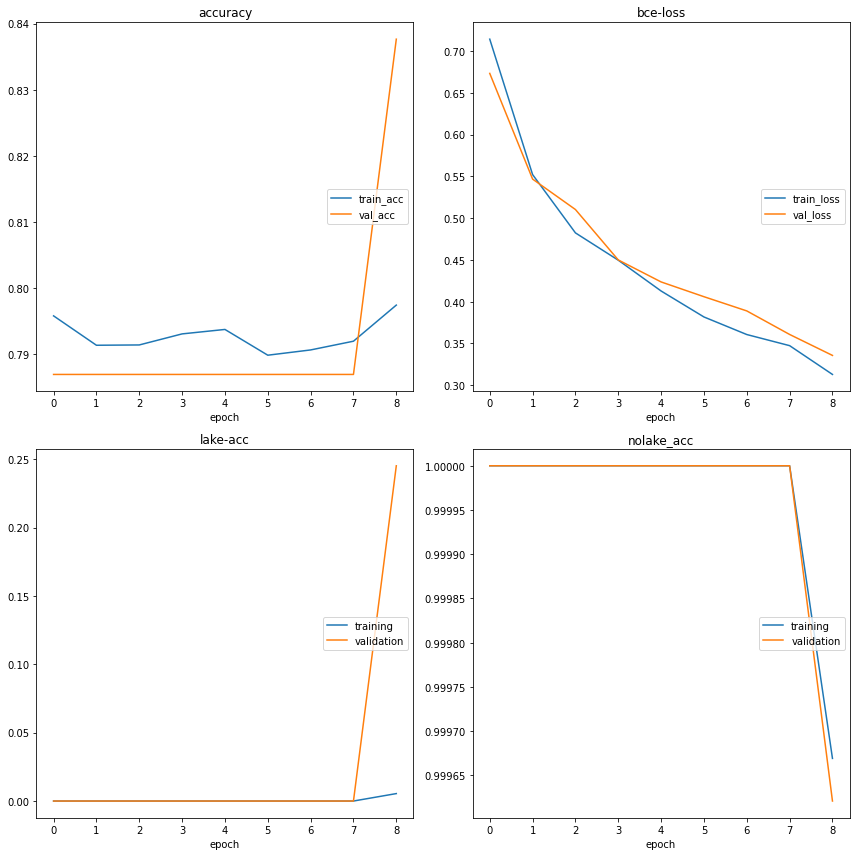

accuracy
	train_acc        	 (min:    0.790, max:    0.797, cur:    0.797)
	val_acc          	 (min:    0.787, max:    0.838, cur:    0.838)
bce-loss
	train_loss       	 (min:    0.313, max:    0.714, cur:    0.313)
	val_loss         	 (min:    0.336, max:    0.673, cur:    0.336)
lake-acc
	training         	 (min:    0.000, max:    0.005, cur:    0.005)
	validation       	 (min:    0.000, max:    0.245, cur:    0.245)
nolake_acc
	training         	 (min:    1.000, max:    1.000, cur:    1.000)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)


In [4]:
bs = cfg['from_scratch_landcover']['batch_size']
ne = cfg['from_scratch_landcover']['num_epochs']
lr = cfg['from_scratch_landcover']['lr']
bs, ne, lr

trainer(cfg['from_scratch_landcover'], train_id=f'from_scratch_small_landcover_bs{bs}_ne{ne}_lr{lr}')

In [5]:
#import matplotlib.pylab as plt

#with open('history-from_scratch_landcover_bs30_ne3_lr0.0001.json', 'r') as f:
#    history_dict = json.load(f)

#plt.plot(history_dict['val_loss'])
#plt.show()